In [1]:
# Notebook to evaluate and run new versions of elementwise comparisons

In [2]:
import sys
sys.path.append('../lib')

from pathlib import Path
from collections import Counter, defaultdict
import json
from pprint import pprint
from itertools import chain, islice
import math

import pandas as pd
import numpy as np
import pymc3 as pm
import arviz as ar
import seaborn as sns

from sklearn import metrics

import pylab as py
from tqdm.notebook import tqdm
# from followthemoney import compare, compare2, model
from followthemoney import compare, model

import compare2_tk as compare2

from profiles import Profile, ProfileCollection, _describe_list, Judgement
import utils
from evaluate import evaluate

/Users/tuomasketola/Documents/followthemoney-compare/followthemoney_compare/notebooks/../lib/profiles.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
profiles = ProfileCollection.load_dir('../data/profiles/')

In [4]:
profiles.describe()

Number of profiles: 1268
Mean profile size: 1.9014195583596214
STD profile size: 2.380036158831663
Median profile size: 2.0
Unique Entities: 2378
Judgement Counts: [(<Judgement.POSITIVE: 'positive'>, 1823), (<Judgement.NEGATIVE: 'negative'>, 546), (<Judgement.UNSURE: 'unsure'>, 42)]
Mean entity num properties: 5.975114060555786
STD entity num properties: 2.81508843052671
Median entity num properties: 7.0


In [5]:
user_weight = utils.create_user_weights_lookup(profiles)

In [6]:
# new evaluation system:
pairs_weights = defaultdict(list)
profile_results1 = defaultdict(list)
profile_results2 = defaultdict(list)
for profile in tqdm(profiles.values()):
    pairs = profile.iter_pairs(judgements={Judgement.POSITIVE, Judgement.NEGATIVE})
    if pairs:
        profile_results1[profile.pid] = []
        profile_results2[profile.pid] = []
        for (e1, e2), judgement in pairs:
            profile_results1[profile.pid].append((judgement.value, compare.compare(model, e1, e2)))
            profile_results2[profile.pid].append((judgement.value, compare2.compare(model, e1, e2)))

  0%|          | 0/1268 [00:00<?, ?it/s]

/Users/tuomasketola/Documents/followthemoney-compare/lib/python3.9/site-packages/followthemoney-2.5.1-py3.9.egg/followthemoney/compare.py:72: FTMPredictWarning: followthemoney.compare uses a simplified model. Use the package followthemoney-predict for a more accurate entity comparison model
  warnings.warn(FTMPredictWarning())
/Users/tuomasketola/Documents/followthemoney-compare/followthemoney_compare/notebooks/../lib/compare2_tk.py:77: FTMPredictWarning: followthemoney.compare uses a simplified model. Use the package followthemoney-predict for a more accurate entity comparison model
  warnings.warn(FTMPredictWarning())


In [7]:
M1_f1, M1_precision, M1_recall = evaluate(profile_results1)

In [8]:
M2_f1, M2_precision, M2_recall = evaluate(profile_results2)

In [9]:
thresholds  = list(M1_f1.keys())

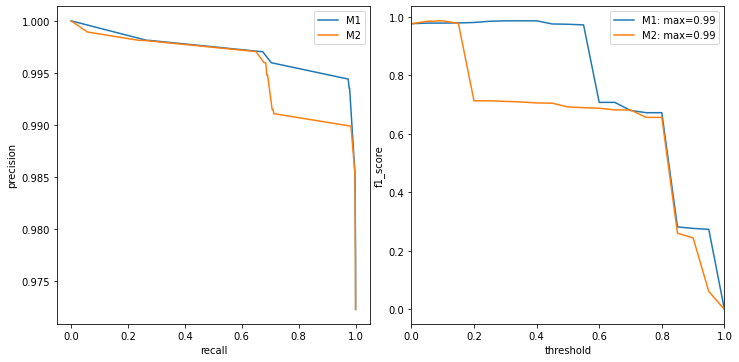

In [10]:
fig, axs = py.subplots(ncols=2, figsize=(10,5))
fig.tight_layout()


axs[0].set_ylabel('precision')
axs[0].set_xlabel('recall')

axs[1].set_ylabel('f1_score')
axs[1].set_xlabel('threshold')

# plot precision / recall curves
axs[0].plot(M1_recall.values(), M1_precision.values(), label='M1')
axs[0].plot(M2_recall.values(), M2_precision.values(), label='M2')
axs[0].legend()

# Plot f1 score
m1_max_f1 = round(max(M1_f1.values()),2)
m2_max_f1 = round(max(M2_f1.values()),2)
axs[1].set_xlim(0,1)
axs[1].plot(list(M1_f1.keys()), M1_f1.values(), label='M1: max={}'.format(m1_max_f1))
axs[1].plot(list(M2_f1.keys()), M2_f1.values(), label='M2: max={}'.format(m2_max_f1))
axs[1].legend()

py.show()